In [36]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# fix the current import path
import sys, os
cwd = os.getcwd()
cdir = os.path.abspath(os.path.join(cwd,".."))
sys.path.insert(0, cdir)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from temporalanalysis.temporal_analysis_ab import compute_avg_behavior, plot_avg_behavior, load_dataset, compute_phase_matrix, plot_phase_matrix, plot_avg_rssi,testbed_phase_matrix
from spatialreuse import compute_spatial_reuse
from align_matrix import apply_phase, align_matrix, traverse_matrix, scale_matrix
from scipy.optimize import leastsq

import matplotlib
matplotlib.matplotlib_fname()
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#PM = testbed_phase_matrix('/Users/ochipara/Working/DirectionalAntennas/data/testbed/tx_temporal/Ch11_Pwr7_MoteA', '2016-10-05_NODE')
PM = testbed_phase_matrix('/Users/ochipara/Working/DirectionalAntennas/data/testbed/tx_temporal/Ch11_Pwr7_MoteA', '2016-10-05_NODE')

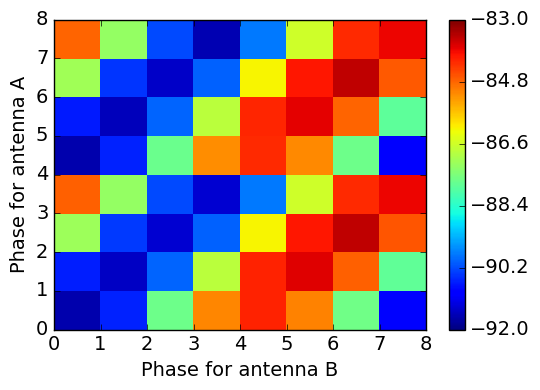

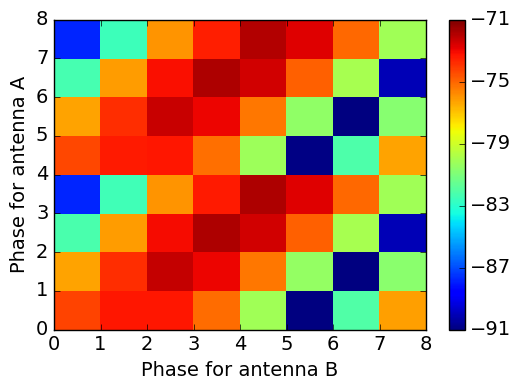

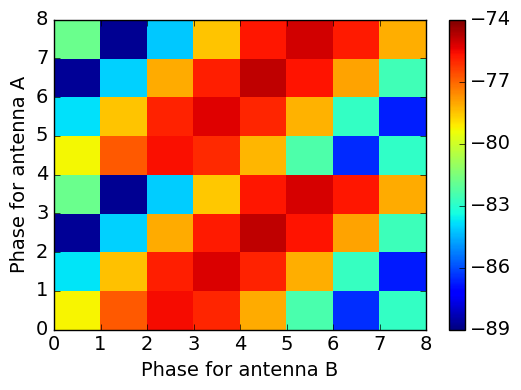

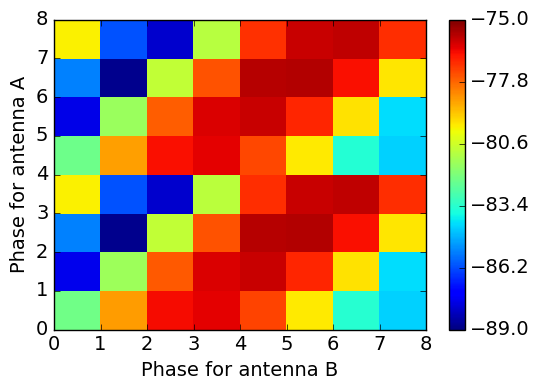

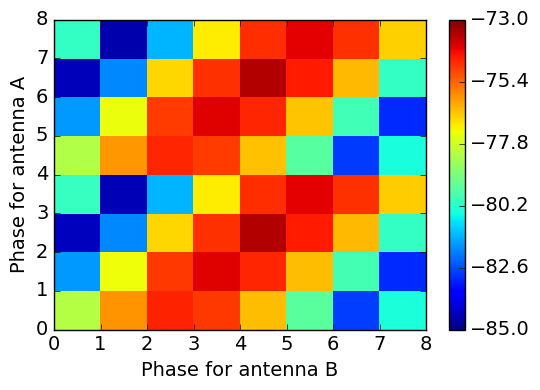

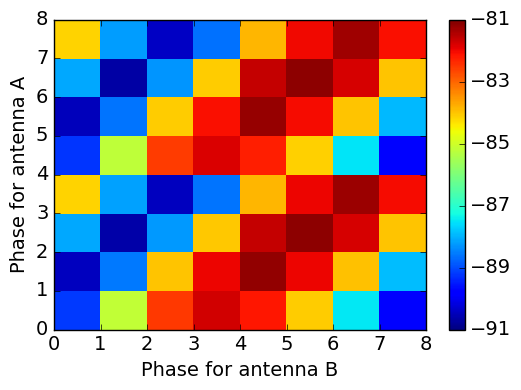

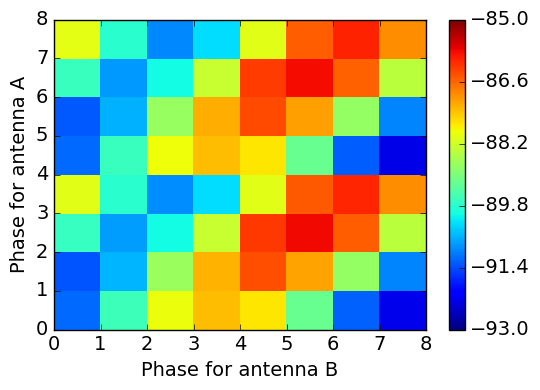

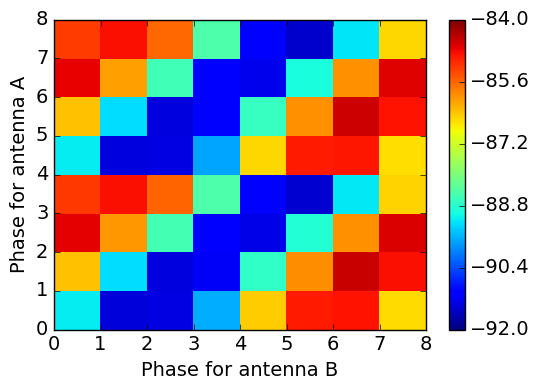

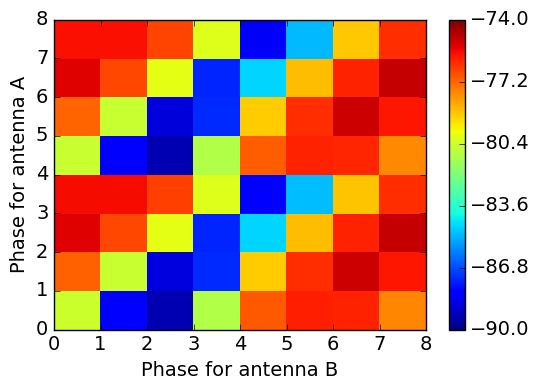

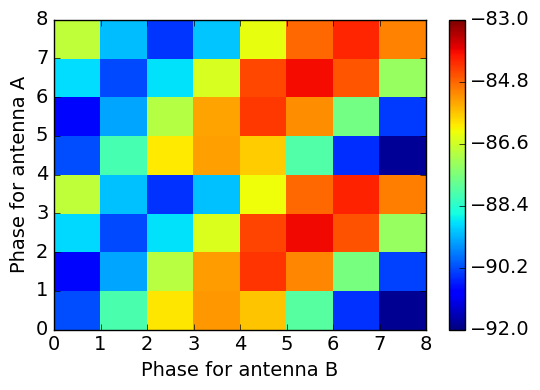

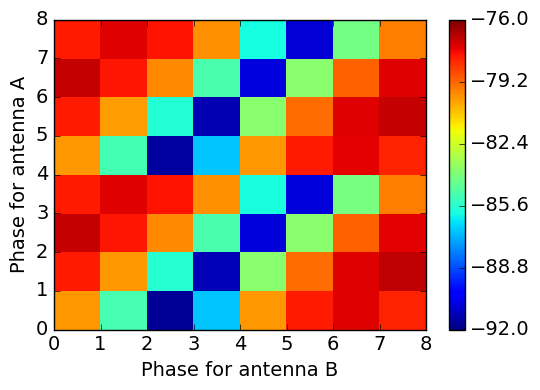

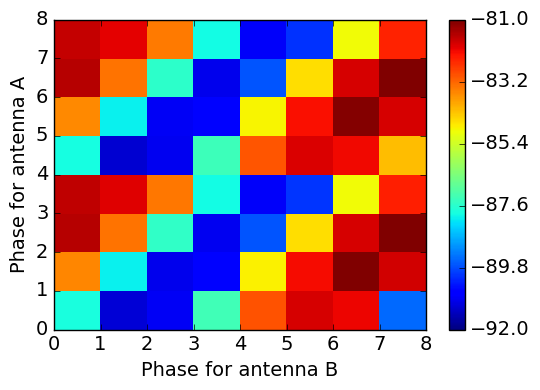

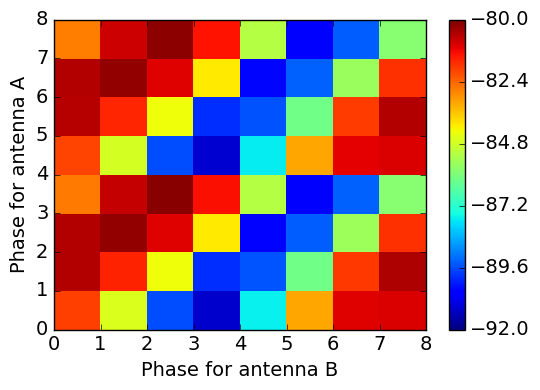

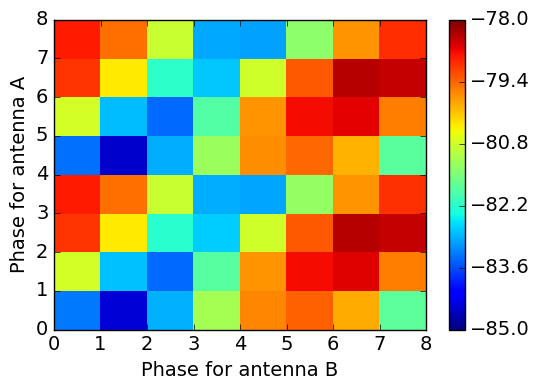

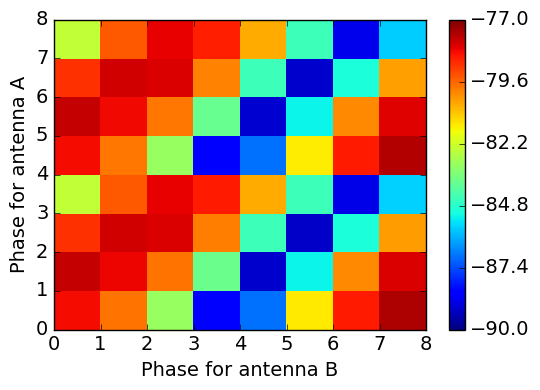

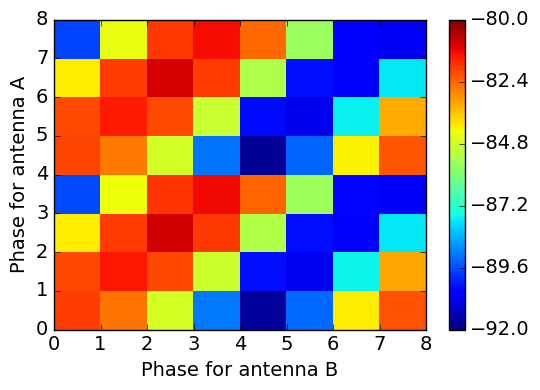

In [3]:
for node in range(16):
    plt.figure()
    plot_phase_matrix(PM[node])
    plt.savefig('figures/phase_matrix/node%d.pdf' % node)
    
for node in range(16):
    m = np.mean(PM[node])
    PM[node] = PM[node] - m

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


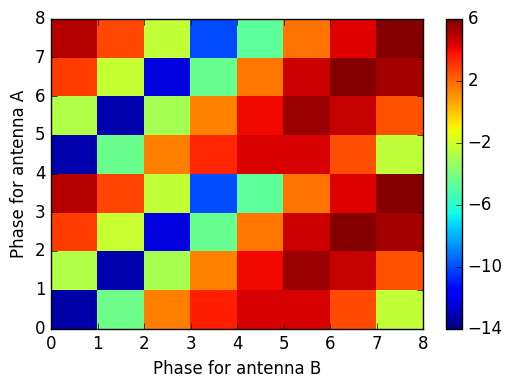

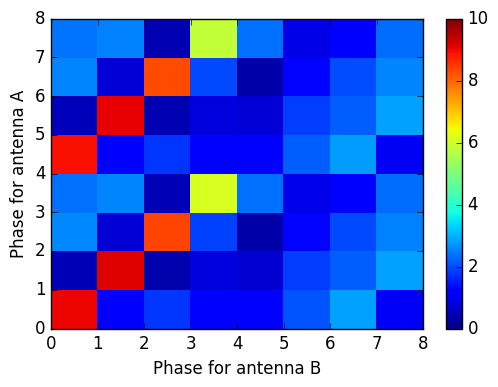

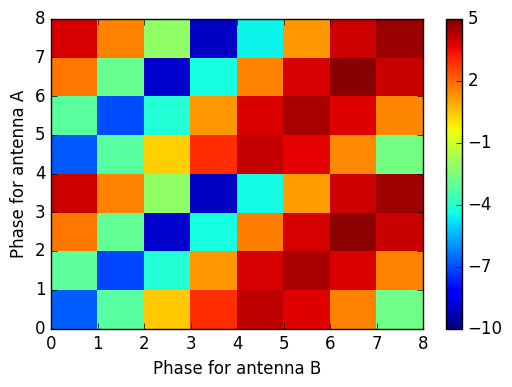

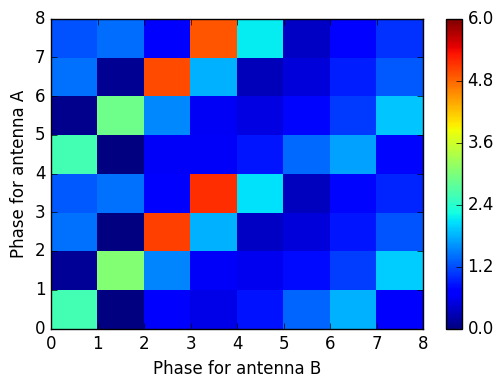

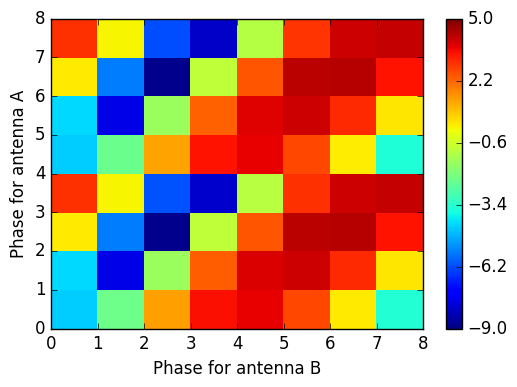

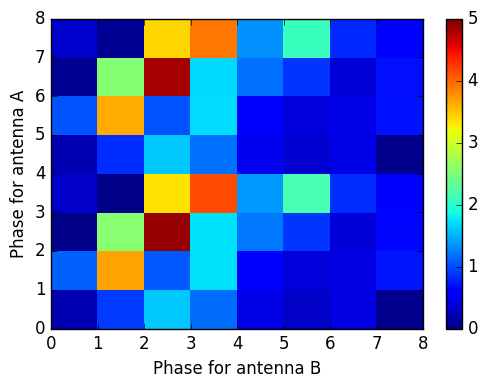

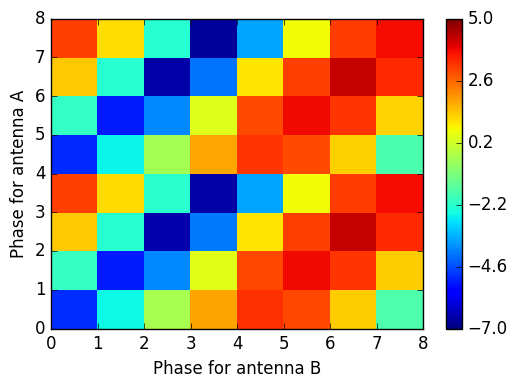

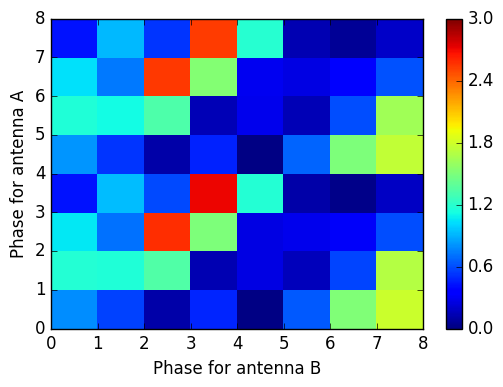

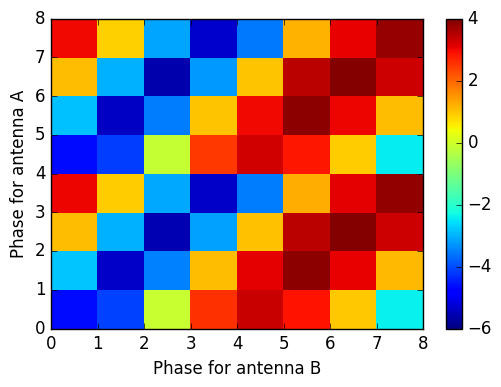

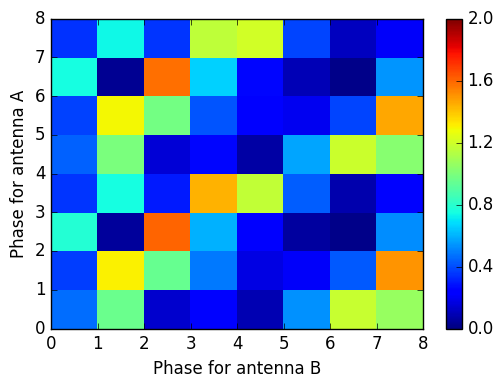

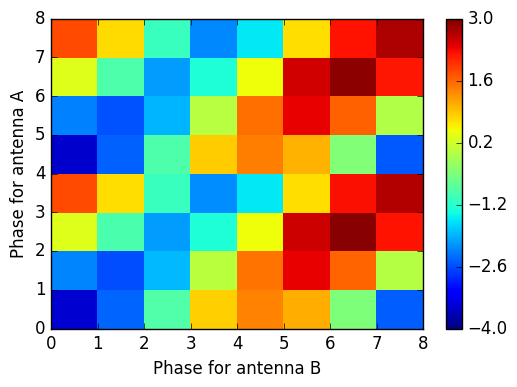

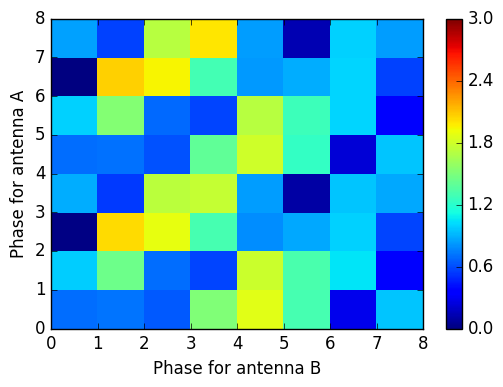

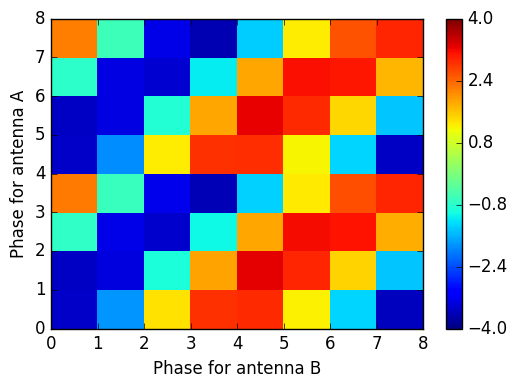

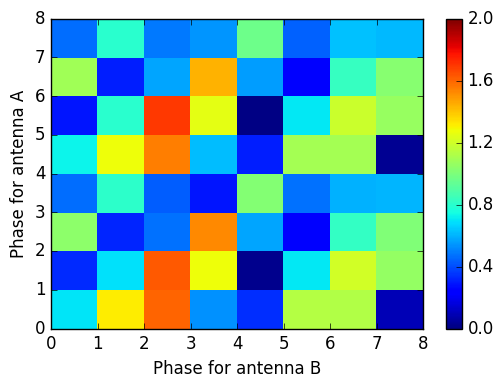

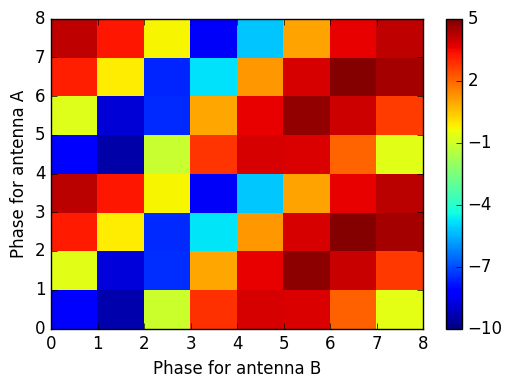

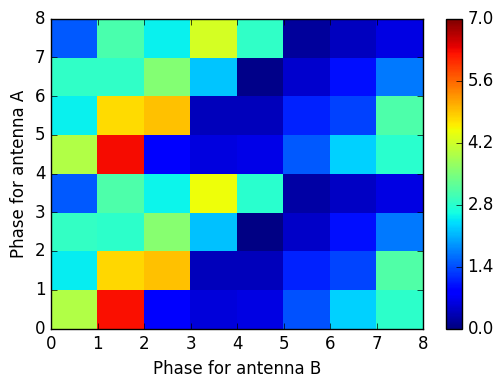

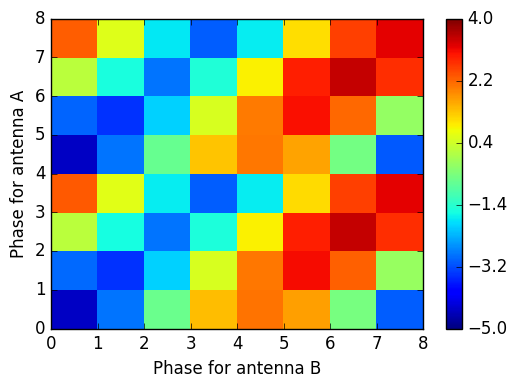

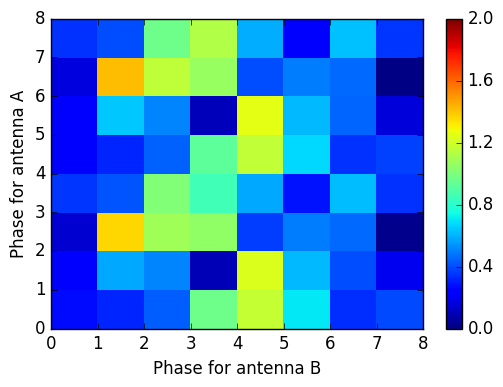

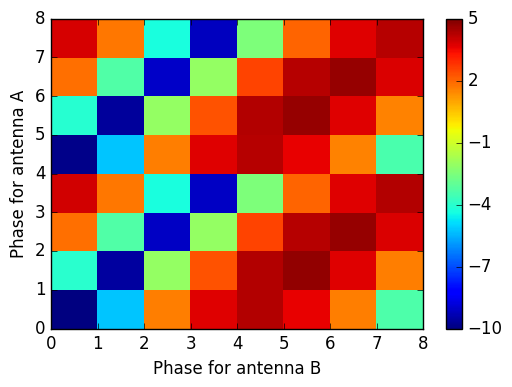

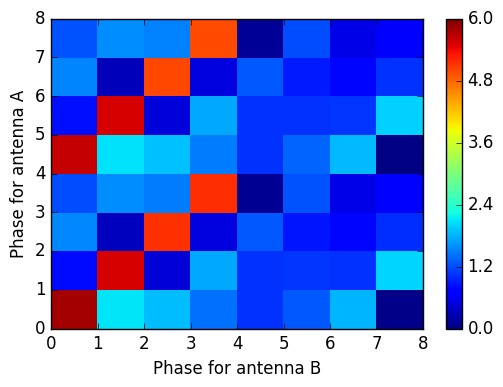

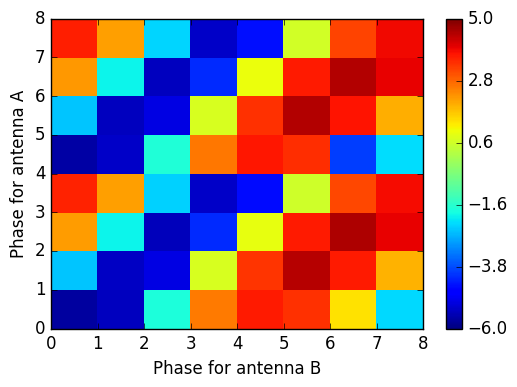

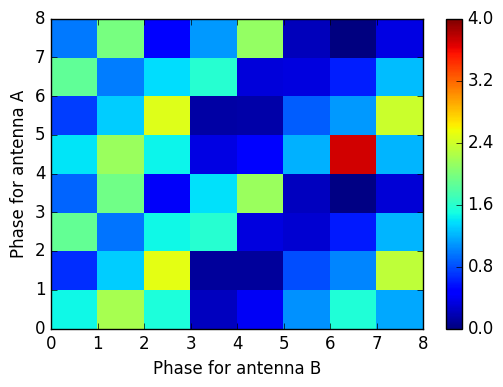

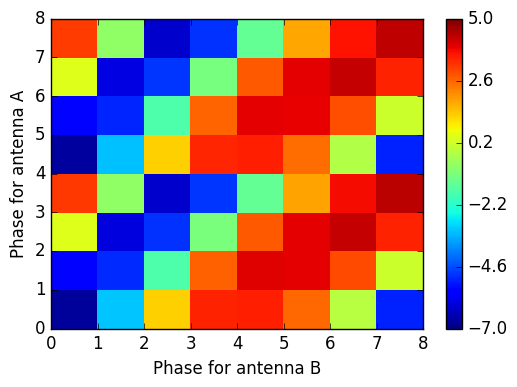

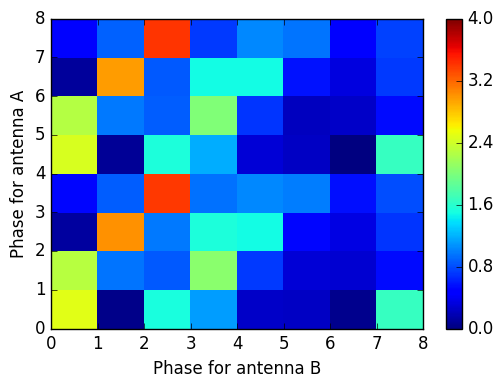

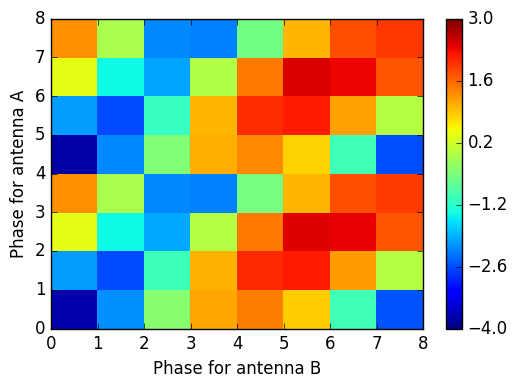

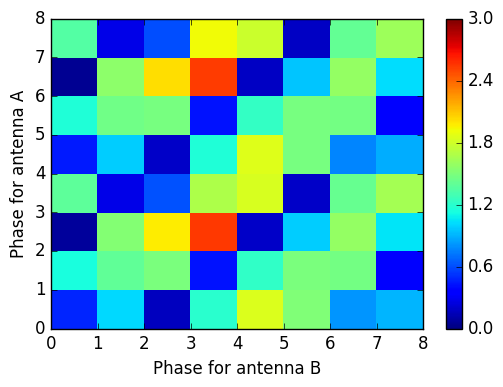

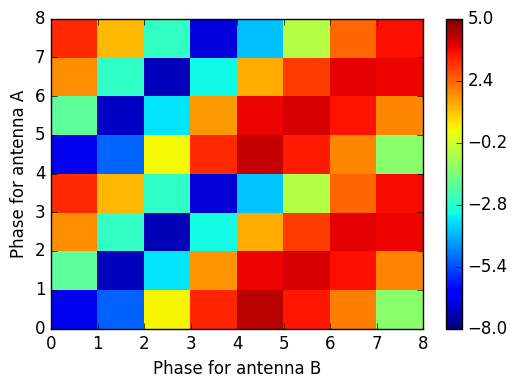

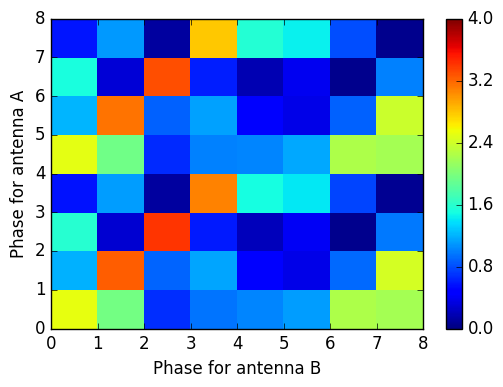

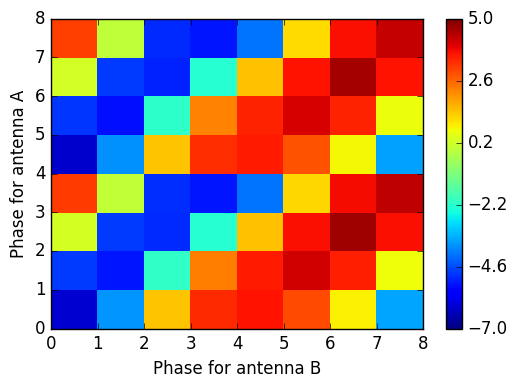

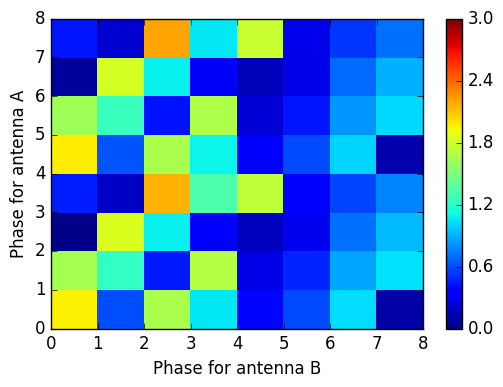

In [40]:
phases = {}
error ={}
for node in range(1, 16):
    phase = align_matrix(PM[0], PM[node])
    phases[node] = phase
    PM[node] = apply_phase(phase, PM[node])
    plt.figure()
    plot_phase_matrix(PM[node])
    plt.savefig('figures/phase_matrix/adjusted_node%d.pdf' % node)

    plt.figure()
    D = abs(PM[node] - PM[0])
    error[node] = D
    plot_phase_matrix(D)
    plt.savefig('figures/phase_matrix/error_%d.pdf' % node)

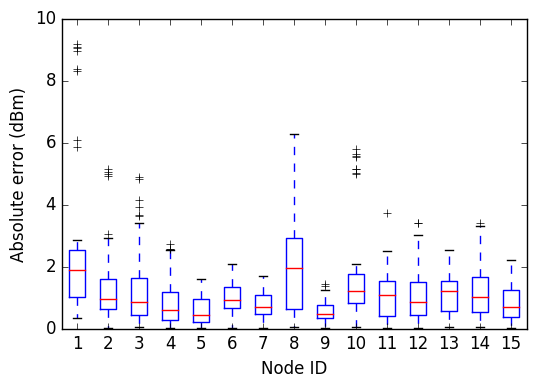

In [50]:
data = [error[node] for node in range(1,16)]
plt.boxplot(data)
plt.xlabel('Node ID')
plt.ylabel('Absolute error (dBm)')
plt.savefig('figures/phase_matrix/error_distr.pdf')


In [51]:
df0 = load_dataset('/Users/ochipara/Working/DirectionalAntennas/data/testbed/tx_temporal/Ch11_Pwr7_MoteA/2016-10-05_NODE%d.csv'% 0)
df1 = load_dataset('/Users/ochipara/Working/DirectionalAntennas/data/testbed/tx_temporal/Ch11_Pwr7_MoteA/2016-10-05_NODE%d.csv'% 8)
PM0 = compute_phase_matrix(df0)
PM1 = compute_phase_matrix(df1)
phase01 = align_matrix(PM1, PM0)
print(phase01)

(0, 7)


In [52]:
PM0_phased = apply_phase(phase01, PM0)
r = leastsq(scale_matrix, [np.mean(PM0), 1], args=(PM1, PM0_phased))[0]
print(r)

[ 46.37613113   1.44381394]


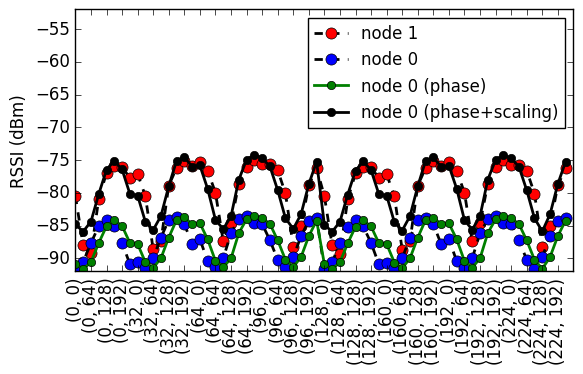

In [53]:
f, rssi_avg1 = plot_avg_rssi(df1)
f, rssi_avg0 = plot_avg_rssi(df0, figure=f, mf='b')
ix = traverse_matrix(phase01)

y = np.array([rssi_avg0.values[x] for x in ix])
plt.plot(np.arange(0, 64), y, 'go-')

y2 = r[0] + r[1] * y
plt.plot(np.arange(0, 64), y2, 'ko-')
plt.legend(['node 1', 'node 0', 'node 0 (phase)', 'node 0 (phase+scaling)'])
plt.ylim(-92, -52)
plt.savefig('figures/phase_matrix/adjusted_link.pdf')
